In [1]:
from keras.layers import Input, Dense, LSTM,Conv1D,Dropout,Bidirectional,Multiply
from keras.models import Model
# from attention_utils import get_activationsfrom keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
import  pandas as pd
import  numpy as np
import keras.backend as K
from keras.layers import concatenate
import xgboost as xgb


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
mng=pd.read_csv('/content/drive/MyDrive/MANAG.csv')
mng.Date=pd.to_datetime(mng.Date ,format='%Y/%m/%d')

In [6]:
mng.head()


,Date,Ouverture,Plus haut,Plus bas,Prix,Quantité
0,2000-07-11,0.00,534.90,534.90,534.90,2190942.50
1,2000-07-12,0.00,534.90,534.90,534.90,0.00
2,2000-07-13,636.83,636.83,636.83,636.83,160361.25
3,2000-07-14,611.59,611.59,611.59,611.59,36120.32
4,2000-07-17,611.59,611.59,611.59,611.59,13980.46


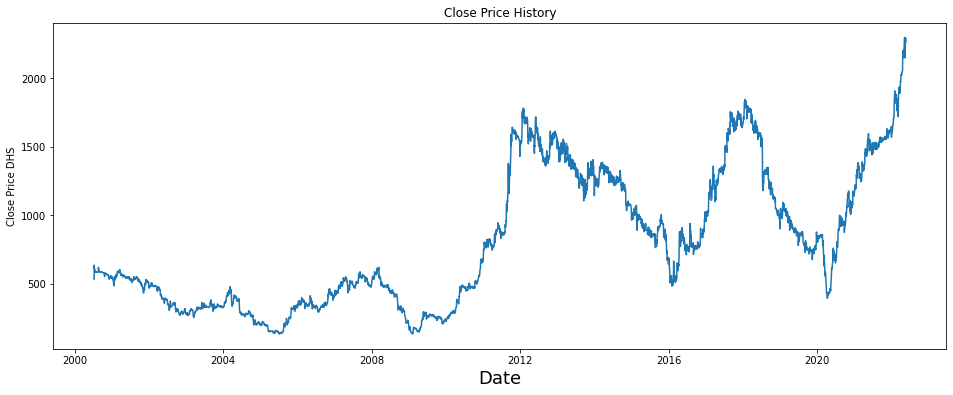

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(mng['Date'], mng['Prix'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price DHS', fontsize=10)
plt.show()

In [8]:
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y
def NormalizeMult(data):
    
    data = np.array(data)
    normalize = np.arange(2*data.shape[1],dtype='float64')

    normalize = normalize.reshape(data.shape[1],2)
    print(normalize.shape)
    for i in range(0,data.shape[1]):
        
        list = data[:,i]
        listlow,listhigh =  np.percentile(list, [0, 100])
        # print(i)
        normalize[i,0] = listlow
        normalize[i,1] = listhigh
        delta = listhigh - listlow
        if delta != 0:
            
            for j in range(0,data.shape[0]):
                data[j,i]  =  (data[j,i] - listlow)/delta
    #np.save("./normalize.npy",normalize)
    return  data,normalize

 
def FNormalizeMult(data,normalize):
    data = np.array(data)
    for i in  range(0,data.shape[1]):
        listlow =  normalize[i,0]
        listhigh = normalize[i,1]
        delta = listhigh - listlow
        if delta != 0:
            
            for j in range(0,data.shape[0]):
                data[j,i]  =  data[j,i]*delta + listlow

    return data

    
def get_activations(model, inputs, print_shape_only=False, layer_name=None):
  
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print('shape为',layer_activations.shape)
            print(layer_activations)
    return activations


def get_data(n, input_dim, attention_column=1):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column] = y[:, 0]
    return x, y


def get_data_recurrent(n, time_steps, input_dim, attention_column=10):
    """
    Data generation. x is purely random except that it's first value equals the target y.
    In practice, the network    should learn that the target = x[attention_column].
    Therefore, most of its attention should be focused on the value addressed by attention_column.
    :param n: the number of samples to retrieve.
    :param time_steps: the number of time steps of your series.
    :param input_dim: the number of dimensions of each element in the series.
    :param attention_column: the column linked to the target. Everything else is purely random.
    :return: x: model inputs, y: model targets
    """
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:, attention_column, :] = np.tile(y[:], (1, input_dim))
    return x, y


def get_data_recurrent2(n, time_steps, input_dim, attention_dim=5):
    x = np.random.standard_normal(size=(n, time_steps, input_dim))
    y = np.random.randint(low=0, high=2, size=(n, 1))
    x[:,:,attention_dim] =  np.tile(y[:], (1, time_steps))


    return x,y



In [9]:
from keras.layers import multiply
SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    #a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = multiply([inputs, a_probs], name='attention_mul')#, mode='mul') 
    return output_attention_mul


def attention_3d_block2(inputs, single_attention_vector=False):
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
  
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [10]:
def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))

    x = Conv1D(filters = 64, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    x = Dropout(0.3)(x)

    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [11]:
data = mng
mng.drop('Date',axis=1,inplace=True)
print(data.columns)
print(data.shape)



Index(['Ouverture', 'Plus haut', 'Plus bas', 'Prix', 'Quantité'], dtype='object')
(5411, 5)


In [12]:
def PredictWithData(data,data_yuan,name,modelname,INPUT_DIMS = 13,TIME_STEPS = 20):
    print(data.columns)
    yindex = data.columns.get_loc(name)
    data = np.array(data, dtype='float64')
    data, normalize = NormalizeMult(data)
    data_y = data[:, yindex]
    data_y = data_y.reshape(data_y.shape[0], 1)

    testX, _ = create_dataset(data)
    _, testY = create_dataset(data_y)
    print("testX Y shape is:", testX.shape, testY.shape)
    if len(testY.shape) == 1:
        testY = testY.reshape(-1, 1)

    model = attention_model(INPUT_DIMS)
    model.load_weights(modelname)
    model.summary()
    y_hat =  model.predict(testX)
    testY, y_hat = xgb_scheduler(data_yuan, y_hat)
    return y_hat, testY

In [13]:
def xgb_scheduler(data,y_hat):
    close = data.pop('close')
    data.insert(5, 'close', close)
    train, test = prepare_data(data, n_test=len(y_hat), n_in=6, n_out=1)
    testY, y_hat2 = walk_forward_validation(train, test)
    return testY, y_hat2

def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # print('train', train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # print('trainX', trainX, 'trainy', trainy)
    # fit model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

def walk_forward_validation(train, test):
    predictions = list()
    train = train.values
    history = [x for x in train]
    # print('history', history)
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        # print('i', i, testX, testy)
        yhat = xgboost_forecast(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i, :])
        print(i+1, '>expected=%.6f, predicted=%.6f' % (testy, yhat))
    return test.iloc[:, -1],predictions

In [75]:
INPUT_DIMS = 5
TIME_STEPS = 20
lstm_units = 64
train_size = int(len(data)*0.8)
train = data.iloc[:train_size,:]
test = data.iloc[train_size:,:]
#train, test = train_test_split(data, test_size=0.1)
print("len(train):",len(train))
print("len(test):",len(test))

len(train): 4328
len(test): 1083


In [ ]:
mng.iloc[:,3]

0        534.90
1        534.90
2        636.83
3        611.59
4        611.59
         ...   
5406    2250.00
5407    2226.00
5408    2240.00
5409    2280.00
5410    2270.00
Name: Plus bas, Length: 5411, dtype: float64

In [ ]:
import keras.backend as K
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
train,normalize = NormalizeMult(train)
priceData = train[:,3].reshape(len(train),1)

train_X, _ = create_dataset(train,TIME_STEPS)
_ , train_Y = create_dataset(priceData,TIME_STEPS)
print(train_X.shape,train_Y.shape)

m = attention_model()
m.summary()
#m.compile(optimizer='adam', loss='mse')
m.compile(loss='mse', optimizer='adam',metrics=['mae',r2_keras])

# fit the network
history =  m.fit([train_X], train_Y, epochs=50, batch_size=64, validation_split=0.1)
# history = m.fit([train_X], train_Y, epochs=10, batch_size=64, validation_split=0.05, verbose=2,
#          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
#                       ModelCheckpoint(m,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
#          )

(5, 2)
(4307, 20, 5) (4307, 1)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 20, 5)]      0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 20, 64)       384         ['input_6[0][0]']                
                                                                                                  
 dropout_10 (Dropout)           (None, 20, 64)       0           ['conv1d_5[0][0]']               
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 20, 128)     66048       ['dropout_10[0][0]']             
 )                                                           

In [21]:
import matplotlib.pyplot as plt

# # summarize history for R^2
# fig_acc = plt.figure(figsize=(10, 10))
# plt.plot(history.history['r2_keras'])
# plt.plot(history.history['val_r2_keras'])
# plt.title('model r^2')
# plt.ylabel('R^2')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()



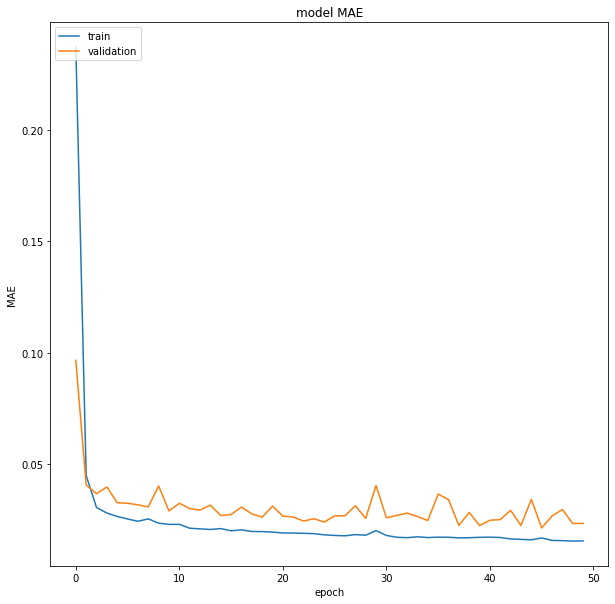

In [22]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


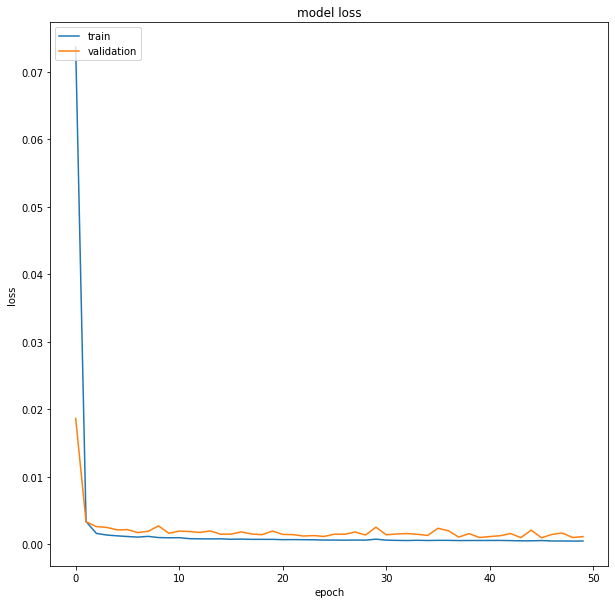

In [76]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [77]:
# TEST
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
test = scaler.fit_transform(test)

# # test,normalize = NormalizeMult(test)
# price_test = test[:,3].reshape(len(test),1)

# test_X, _ = create_dataset(test,TIME_STEPS)
# _ , test_Y = create_dataset(price_test,TIME_STEPS)
# print(test_X.shape,test_Y.shape)
# test,normalize = NormalizeMult(test)
price_test = test[:,3].reshape(len(test),1)

test_X, _ = create_dataset(test,TIME_STEPS)
_ , test_Y = create_dataset(price_test,TIME_STEPS)
print(test_X.shape,test_Y.shape)



(1062, 20, 5) (1062, 1)


In [78]:
# Prediction
scores_test = m.evaluate([test_X], test_Y, verbose=2)

# test_Y.reshape(-1, 1)
# price_test.reshape(-1, 1)

34/34 - 1s - loss: 0.0067 - mae: 0.0660 - 821ms/epoch - 24ms/step


In [50]:
#inverse transform

In [82]:
# test_X = test.reshape(1, test.shape[0], test.shape[1])
y_hat = m.predict(test_X)
y_hat = y_hat.reshape(-1,1)
y_hat = reshape_y_hat(y_hat, 1)

    #反歸一化
y_hat = scaler.inverse_transform(results)


ValueError: ignored

In [80]:
# results = m.predict([test_X])
y_hat

array([[0.7396428 ],
       [0.7262522 ],
       [0.74354464],
       ...,
       [0.93785965],
       [0.93746346],
       [0.93756115]], dtype=float32)

In [67]:
def reshape_y_hat(y_hat,dim):
    re_y = []
    i = 0
    while i < len(y_hat):
        tmp = []
        for j in range(dim):
            tmp.append(y_hat[i+j])
        i = i + dim
        re_y.append(tmp)
    re_y = np.array(re_y, dtype='float64')
    return re_y


In [ ]:
# test.shape
# if len(test.shape) == 1:
#         testY = testY.reshape(-1, 1)


In [57]:
# results = m.predict([test_X])

In [58]:
# scaler.inverse_transform(price_test)
# results =scaler.inverse_transform(results)

In [74]:
results=scaler.inverse_transform(results)

ValueError: ignored

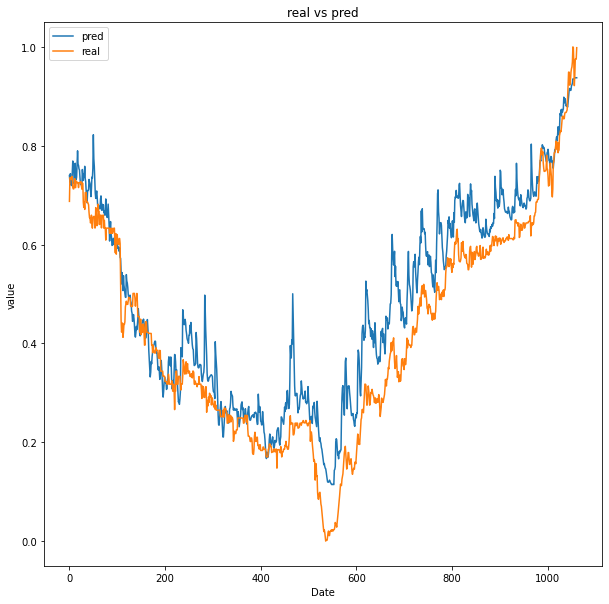

In [72]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(y_hat)
plt.plot(test_Y)
plt.title('real vs pred')
plt.ylabel('value')
plt.xlabel('Date')
plt.legend(['pred', 'real'], loc='upper left')
plt.show()

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((results- test_Y) ** 2)))
print('RMSE: '+str(rmse))
  #mean absolute error
mae = mean_absolute_error(test_Y, results)
print('MAE: '+str(mae))



RMSE: 0.08176693967602552
MAE: 0.06602867746798506


Since the model has good results we will be able now to predict the next few days....

In [ ]:
#######